##Test out UGRID-0.9 compliant unstructured grid model datasets with PYUGRID

In [1]:
name_list=['sea_surface_elevation',
           'sea_surface_height_above_geoid',
           'sea_surface_height','water level',
           'sea_surface_height_above_sea_level',
           'water_surface_height_above_reference_datum',
           'sea_surface_height_above_reference_ellipsoid']


models = dict(ADCIRC=('http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/'
                      'UND_ADCIRC/Hurricane_Ike_2D_final_run_with_waves'),
              FVCOM=('http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/'
                     'Forecasts/NECOFS_GOM3_FORECAST.nc'),
              SELFE=('http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/'
                     'VIMS_SELFE/Hurricane_Ike_2D_final_run_with_waves'),
              WW3=('http://comt.sura.org/thredds/dodsC/data/comt_2/pr_inundation_tropical/EMC_ADCIRC-WW3/'
                   'Dec2013Storm_2D_preliminary_run_1_waves_only'))

In [2]:
import iris
iris.FUTURE.netcdf_promote = True


def cube_func(cube):
    return (cube.standard_name in name_list) and (not any(m.method == 'maximum' for m in cube.cell_methods))

constraint = iris.Constraint(cube_func=cube_func)

cubes = dict()
for model, url in models.items():
    cube = iris.load_cube(url, constraint)
    cubes.update({model: cube})

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1301: UserWarning: Ignoring netCDF variable 'ele' invalid units 'non-dimensional'
  warnings.warn(msg.format(msg_name, msg_units))
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1301: UserWarning: Ignoring netCDF variable 'Cs' invalid units 'non-dimensional'
  warnings.warn(msg.format(msg_name, msg_units))
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1301: UserWarning: Ignoring netCDF variable 'sigma' invalid units 'non-dimensional'
  warnings.warn(msg.format(msg_name, msg_units))
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1301: UserWarning: Ignoring netCDF variable 'swan_TMM10' invalid units 'metric'
  warnings.warn(msg.format(msg_name, msg_units))
/

In [3]:
cubes

{'ADCIRC': <iris 'Cube' of sea_surface_height_above_geoid / (unknown) (time: 1728; -- : 417642)>,
 'FVCOM': <iris 'Cube' of sea_surface_height_above_geoid / (meters) (time: 145; -- : 51216)>,
 'SELFE': <iris 'Cube' of sea_surface_height_above_geoid / (m) (time: 120; -- : 592761)>,
 'WW3': <iris 'Cube' of sea_surface_height_above_geoid / (m) (time: 8; -- : 254565)>}

In [4]:
import pyugrid
import matplotlib.tri as tri


def get_mesh(cube, url):
    ug = pyugrid.UGrid.from_ncfile(url)
    cube.mesh = ug
    cube.mesh_dimension = 1
    return cube
    
def get_triang(cube):
    lon = cube.mesh.nodes[:, 0]
    lat = cube.mesh.nodes[:, 1]
    nv = cube.mesh.faces
    return tri.Triangulation(lon, lat, triangles=nv)

In [5]:
tris = dict()

for model, cube in cubes.items():
    url = models[model]
    cube = get_mesh(cube, url)
    cubes.update({model: cube})
    tris.update({model: get_triang(cube)})

In [6]:
%matplotlib inline

import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def plot_model(model):
    cube = cubes[model]
    lon = cube.mesh.nodes[:, 0]
    lat = cube.mesh.nodes[:, 1]
    ind = -1 # just take the last time index for now
    zcube = cube[ind]
    triang = tris[model]

    fig, ax = plt.subplots(figsize=(7, 7),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    ax.coastlines()
    levs = np.arange(-1, 5, 0.2)
    cs = ax.tricontourf(triang, zcube.data, levels=levs)
    fig.colorbar(cs)
    ax.tricontour(triang, zcube.data, colors='k',levels=levs)
    tvar = cube.coord('time')
    tstr = tvar.units.num2date(tvar.points[ind])
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    title = ax.set_title('%s: Elevation (m): %s' % (zcube.attributes['title'], tstr))
    return fig, ax

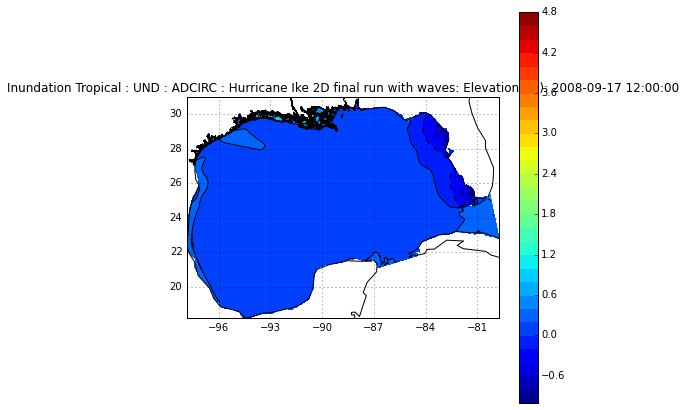

In [7]:
fig, ax = plot_model('ADCIRC')

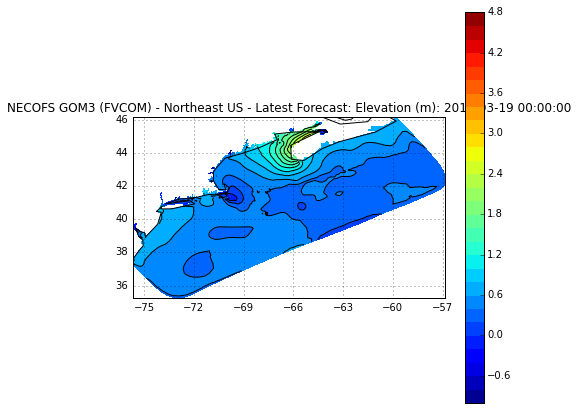

In [8]:
fig, ax = plot_model('FVCOM')

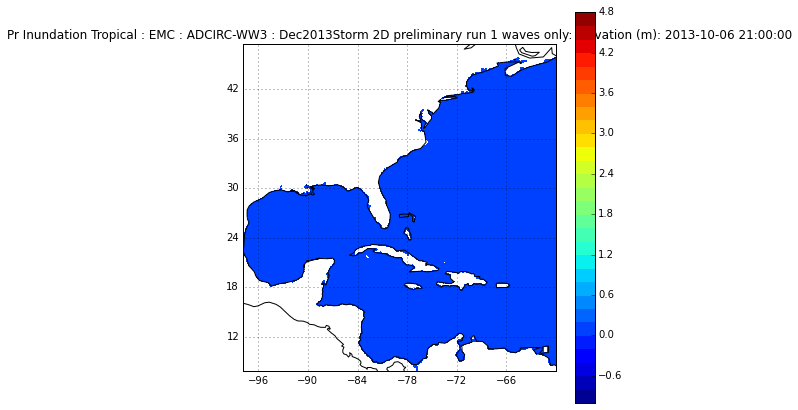

In [9]:
fig, ax = plot_model('WW3')

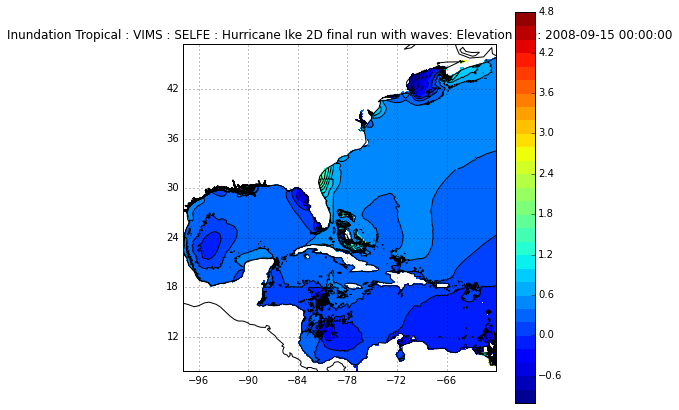

In [10]:
fig, ax = plot_model('SELFE')